# Train Segmentation with Atrous Convolution


#### References
* https://arxiv.org/pdf/1709.00179.pdf
* https://medium.com/beyondminds/a-simple-guide-to-semantic-segmentation-effcf83e7e54
* https://medium.com/dair-ai/medical-imaging-analysis-mri-cnn-pytorch-4877e64e7303

In [1]:
import sat_utils
import numpy as np
import pickle
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Pytorch stuff
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch
import torch.utils.data as utils
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter
from torch.optim import lr_scheduler

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

lr=0.001
l2_norm=0.0000001
gamma=0.1
batch_size = 20
num_epochs = 100

Device: cuda:1


#### Load Data from pickle (Bad not scalable) and create data loader

In [2]:
X = sat_utils.read_pickle_data('./data/input.pickle')
Y = sat_utils.read_pickle_data('./data/label.pickle')
tensor_x = torch.stack([torch.Tensor(x) for x in X.values()])
#tensor_y = torch.stack([torch.Tensor(np.expand_dims(x[0,:,:],axis=0)).type(torch.LongTensor) for x in Y.values()])
tensor_y = torch.stack([torch.Tensor(np.expand_dims(x[0,:,:],axis=0)) for x in Y.values()])

dataset_train = utils.TensorDataset(tensor_x,tensor_y)
dataloader_train = utils.DataLoader(dataset_train, batch_size=batch_size)

In [3]:
print('Input:',tensor_x.shape)
print('Label:',tensor_y.shape)

Input: torch.Size([40, 8, 76, 76])
Label: torch.Size([40, 1, 76, 76])


In [4]:
tensor_x.shape[2]

76

In [12]:
class CrossEntropyLoss2d(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(CrossEntropyLoss2d, self).__init__()
        self.nll_loss = nn.NLLLoss2d(weight, size_average)

    def forward(self, inputs, targets):
        return self.nll_loss(F.log_softmax(inputs), targets)

#### Define Model

In [13]:
# Input 76x76 output 16x16
class AtrousSeg(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        self.model = nn.Sequential(    
            nn.Conv2d(8, 64, kernel_size=3, stride=1, padding=1, dilation = 1), # Front           
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, dilation = 1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0, dilation = 2),            
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=0, dilation = 2),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=0, dilation = 3),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=0, dilation = 3),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=0, dilation = 3),            
            nn.ReLU(),
            nn.BatchNorm2d(256),
            
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=0, dilation = 3), #LFE
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, dilation = 3), 
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, dilation = 3), 
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, dilation = 2), 
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, dilation = 2), 
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, dilation = 1), 
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, dilation = 1),             
            nn.ReLU(),
            nn.BatchNorm2d(256),
            
            nn.Conv2d(256, 1024, kernel_size=7, stride=1, padding=1, dilation = 3), # Head (44x44)
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            nn.Conv2d(1024, 1024, kernel_size=1, stride=1, dilation = 1), 
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            nn.Conv2d(1024, num_classes, kernel_size=1, stride=1, dilation = 1),    
            nn.UpsamplingBilinear2d(size=(76, 76)),
        )
        # Initialize Weights
        for m in self.model:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):        
        return self.model(x)

In [14]:
model = AtrousSeg(num_classes=1)
#resp = model(torch.rand(1, 8, 76, 76))

In [15]:
writer = SummaryWriter('./logs')
dummy_x = torch.rand(1, 8, 76, 76)
writer.add_graph(model, dummy_x)

In [16]:
model.to(device)

AtrousSeg(
  (model): Sequential(
    (0): Conv2d(8, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), dilation=(2, 2))
    (7): ReLU()
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), dilation=(2, 2))
    (10): ReLU()
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), dilation=(3, 3))
    (13): ReLU()
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Conv2d(256, 256, kernel_size=(3, 3), stri

In [ ]:
#loss_fn = nn.CrossEntropyLoss()
#loss_fn = CrossEntropyLoss2d()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_norm)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=gamma)

#### Train Model

Epoch: 0 of: 100 loss: 36170.3984375


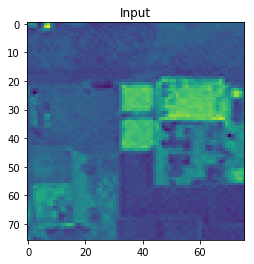

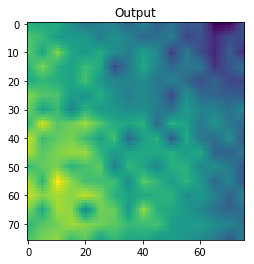

Epoch: 1 of: 100 loss: 26210.982421875


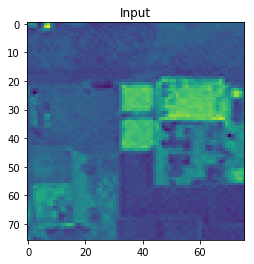

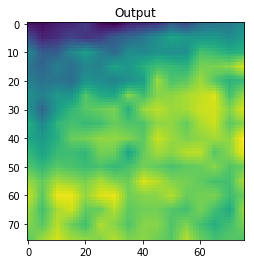

Epoch: 2 of: 100 loss: 20920.509765625


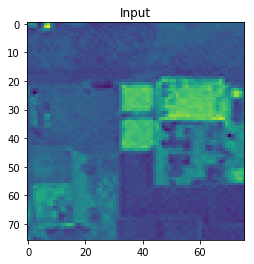

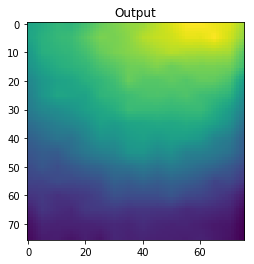

Epoch: 3 of: 100 loss: 18008.095703125


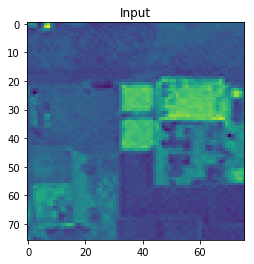

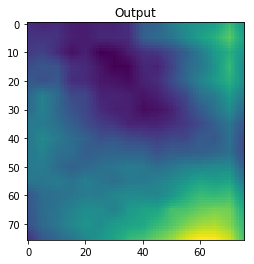

Epoch: 4 of: 100 loss: 16226.7841796875


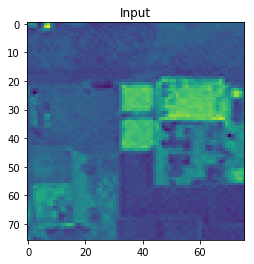

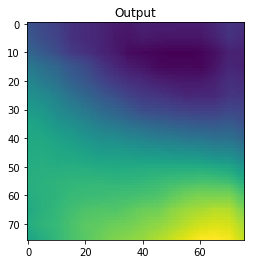

Epoch: 5 of: 100 loss: 15279.638671875


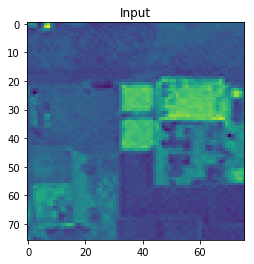

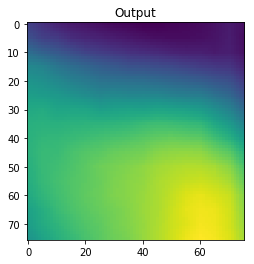

Epoch: 6 of: 100 loss: 14740.1171875


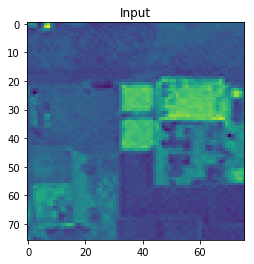

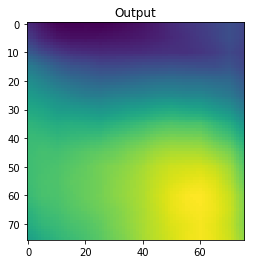

Epoch: 7 of: 100 loss: 13754.8876953125


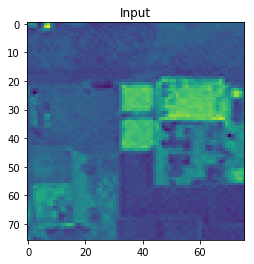

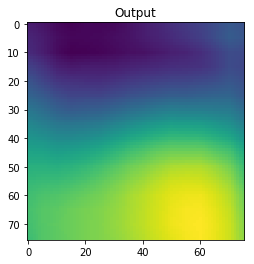

Epoch: 8 of: 100 loss: 13045.8818359375


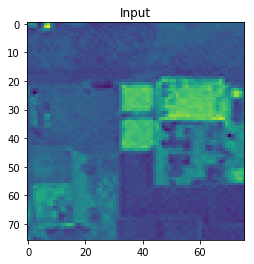

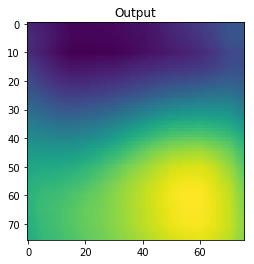

Epoch: 9 of: 100 loss: 12356.099609375


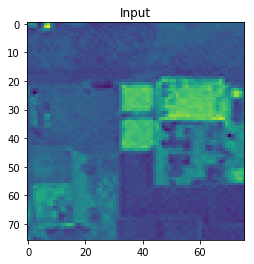

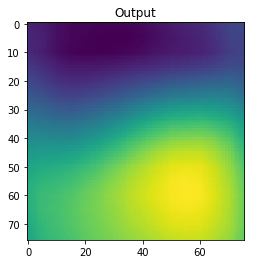

Epoch: 10 of: 100 loss: 11661.4404296875


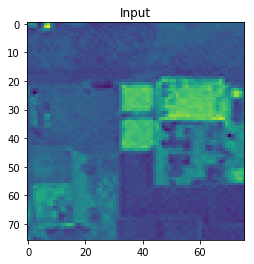

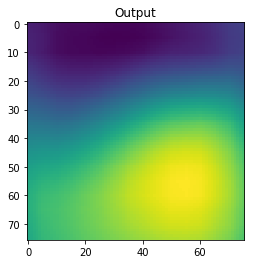

Epoch: 11 of: 100 loss: 11026.6767578125


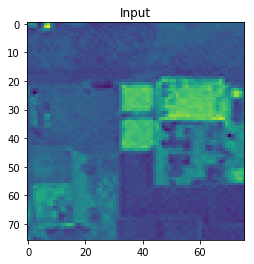

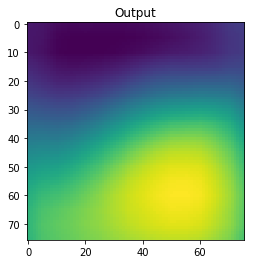

Epoch: 12 of: 100 loss: 10580.259765625


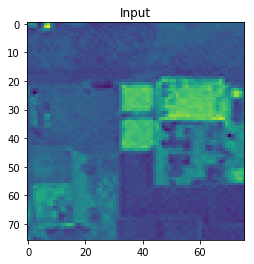

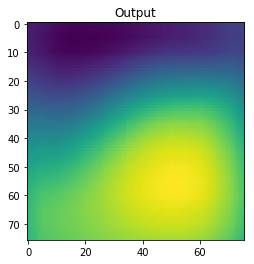

Epoch: 13 of: 100 loss: 10224.8154296875


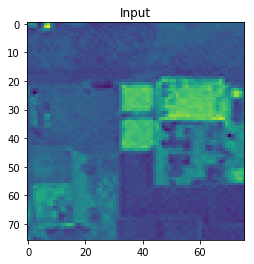

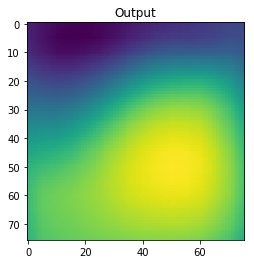

Epoch: 14 of: 100 loss: 9979.646484375


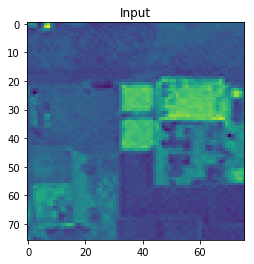

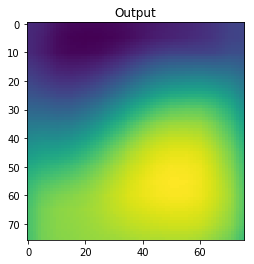

Epoch: 15 of: 100 loss: 9916.32421875


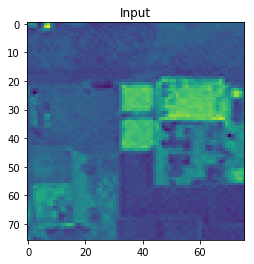

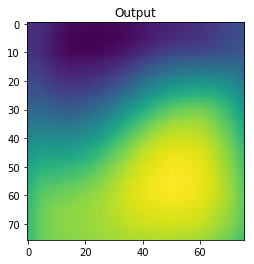

Epoch: 16 of: 100 loss: 9198.7509765625


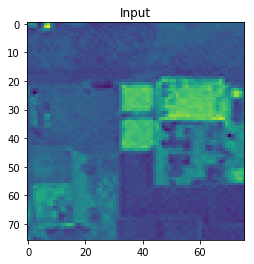

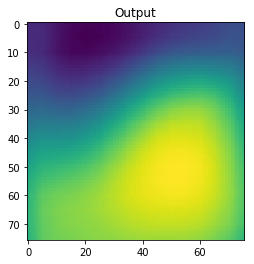

Epoch: 17 of: 100 loss: 8522.9306640625


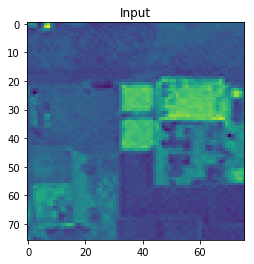

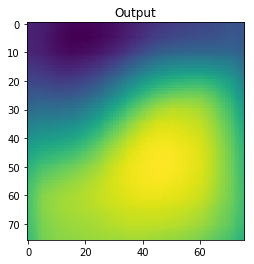

Epoch: 18 of: 100 loss: 8190.48486328125


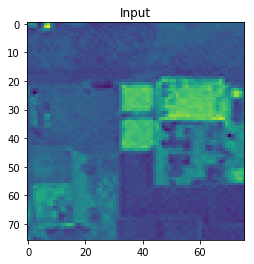

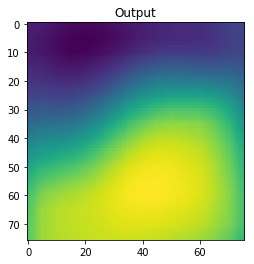

Epoch: 19 of: 100 loss: 7933.0537109375


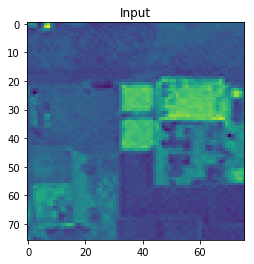

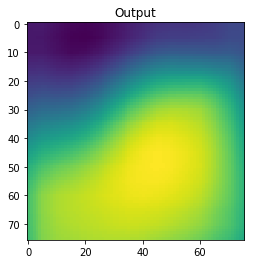

Epoch: 20 of: 100 loss: 7519.216796875


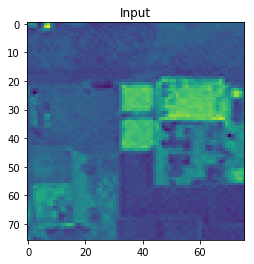

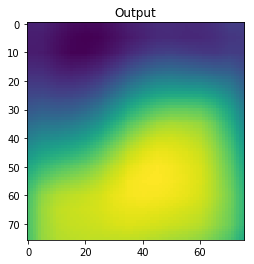

Epoch: 21 of: 100 loss: 7090.3115234375


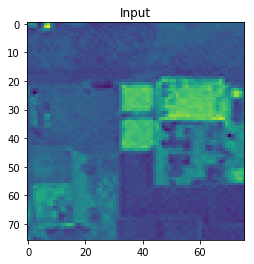

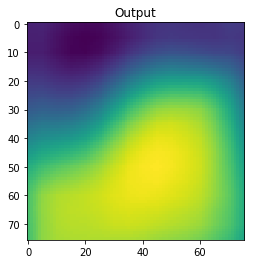

In [ ]:
iteration_count = 0
# For all epochs
for epoch in range(num_epochs):
    # Train step
    model.train()    
    # For all elements on the training set
    for i, (imgs, labels) in enumerate(dataloader_train):
        # Send inputs/labels to GPU                
        labels = labels.to(device)
        imgs = imgs.to(device)                
        
        optimizer.zero_grad()
        
        outputs = model(imgs)
        
        loss = loss_fn(outputs, labels)        
        
        loss.backward()
        optimizer.step()
        writer.add_scalar('loss/', loss.item(), iteration_count)        
        iteration_count+=1        
    print('Epoch:', epoch, 'of:', num_epochs, 'loss:', loss.item())
    #writer.add_image('Image', imgs[:, 4, :, :].permute(0, 2, 1).unsqueeze(1), epoch)
    #writer.add_image('Image', imgs[:, 4, :, :].type(torch.LongTensor), epoch)
    #writer.add_image('Output', outputs[:, 0, :, :].type(torch.LongTensor), epoch)
    # Send to tensorboard loss
    plt.imshow(imgs[0,4,:,:].cpu())
    plt.title('Input');
    plt.show()

    plt.imshow(outputs[0,0,:,:].detach().cpu())
    plt.title('Output');
    plt.show()
    